<a href="https://colab.research.google.com/github/sangam0406/GEN-AI/blob/main/project_customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer segmentation

____

This notebook aims at analyzing the content of an E-commerce database that lists purchases made by $\sim$4000 customers over a period of one year (from 2010/12/01 to 2011/12/09).<br>


___
**1. Data Preparation**

**2. Exploring the content of variables**

   - 2.1 Countries
   - 2.2 Customers and products
       * 2.2.1 Cancelling orders
       * 2.2.2 StockCode
       * 2.2.3 Basket price

**3. Insight on product categories**

   - 3.1 Product description
   - 3.2 Defining product categories
       * 3.2.1 Data encoding
       * 3.2.2 Clusters of products
       * 3.2.3 Characterizing the content of clusters
   
**4. Customer categories**

   - 4.1 Formating data
       * 4.1.1 Grouping products
       * 4.1.2 Grouping orders
   - 4.2 Creating customer categories
       * 4.2.1 Data enconding
       * 4.2.2 Creating categories

**5. Classifying customers**

   - 5.1 Support Vector Machine Classifier (SVC)
       * 5.1.1 Confusion matrix
       * 5.1.2 Learning curves
   - 5.2 Logistic regression
   - 5.3 k-Nearest Neighbors
   - 5.4 Decision Tree
   - 5.5 Random Forest


## 1. Data preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
nltk.download('all')
import matplotlib.cm as cm
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import  model_selection, metrics
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\aathe\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\aathe\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\aathe\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\aathe\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\aathe\AppData\Roaming\nltk_data...
[nltk_data]    | 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df_initial = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})

print('Dataframe dimensions:', df_initial.shape)

df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)
display(df_initial[:5])

Dataframe dimensions: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [ ]:
# deleting tuples with null CustomerID
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)

tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print('Duplicate Entries: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplicate Entries: 5225


___
## 2. Exploring the content of variables

This dataframe contains 8 variables that correspond to:

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  <br>
**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
**Description**: Product (item) name. Nominal. <br>
**Quantity**: The quantities of each product (item) per transaction. Numeric.	<br>
**InvoiceDate**: Invoice Date and time. Numeric, the day and time when each transaction was generated. <br>
**UnitPrice**: Unit price. Numeric, Product price per unit in sterling. <br>
**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
**Country**: Country name. Nominal, the name of the country where each customer resides.<br>

___
### 2.1 Countries

In [ ]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('No. of countries in the dataframe: {}'.format(len(countries)))

No. of countries in the dataframe: 37


In [ ]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],
reversescale = False)

layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

We see that the dataset is largely dominated by orders made from the UK.

___
### 2.2 Customers and products


In [ ]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


In [ ]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


The first lines of this list shows several things worthy of interest:
- the existence of entries with the prefix C for the **InvoiceNo** variable: this indicates transactions that have been canceled
- the existence of users who only came once and only purchased one product (e.g. nº12346)
- the existence of frequent users that buy a large number of items at each order

___
#### 2.2.1 Cancelled orders



In [ ]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])

n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


In [ ]:
display(df_initial.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


Hypothesis:
On these few lines, we see that when an order is canceled, we have another transactions in the dataframe, mostly identical except for the **Quantity** and **InvoiceDate** variables. Wedecide to check if this is true for all the entries.

In [ ]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1])
                & (df_initial['Description'] == col[2])].shape[0] == 0:
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


We see that the initial hypothesis is not fulfilled because of the existence of a  '_Discount_' entry. We check again the hypothesis but this time discarding the '_Discount_' entries:

In [ ]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1])
                & (df_initial['Description'] == col[2])].shape[0] == 0:
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED




At this point, we decide to create a new variable in the dataframe that indicate if part of the command has been canceled. For the cancellations without counterparts, a few of them are probably due to the fact that the buy orders were  performed before December 2010 (the point of entry of the database). Below, we make a census of the cancel orders and check for the existence of counterparts:

In [ ]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) &
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) &
                         (df_initial['Quantity']   > 0)].copy()

    # Cancelation WITHOUT counterpart
    if df_test.shape[0] == 0:
        doubtfull_entry.append(index)

    # Cancelation WITH a counterpart
    elif df_test.shape[0] == 1:
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)

    # Various counterparts exist in orders: we delete the last one
    elif df_test.shape[0] > 1:
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index)
            break

In [ ]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


Among these entries, the lines listed in the * doubtfull_entry * list correspond to the entries indicating a cancellation but for which there is no command beforehand. In practice, we decide to delete all of these entries, which count respectively for  $\sim$1.4% and 0.2% of the dataframe entries.

Now we check the number of entries that correspond to cancellations and that have not been deleted with the previous filter:

In [ ]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("no of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

no of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


If one looks, for example, at the purchases of the consumer of one of the above entries and corresponding to the same product as that of the cancellation, one observes:

In [ ]:
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled


We see that the quantity canceled is greater than the sum of the previous purchases.
___
#### 2.2.2 StockCode

Above, it has been seen that some values of the ** StockCode ** variable indicate a particular transaction (i.e. D for _Discount_). We check the contents of this variable by looking for the set of codes that would contain only letters:

In [ ]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [ ]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                



___
#### 2.2.3 Basket Price

In [ ]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7


Each entry of the dataframe indicates prizes for a single kind of product. Hence, orders are split on several lines. We collect all the purchases made during a single order to recover the total order prize:

In [ ]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,2011-06-09 13:01:00.000000000
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000000000


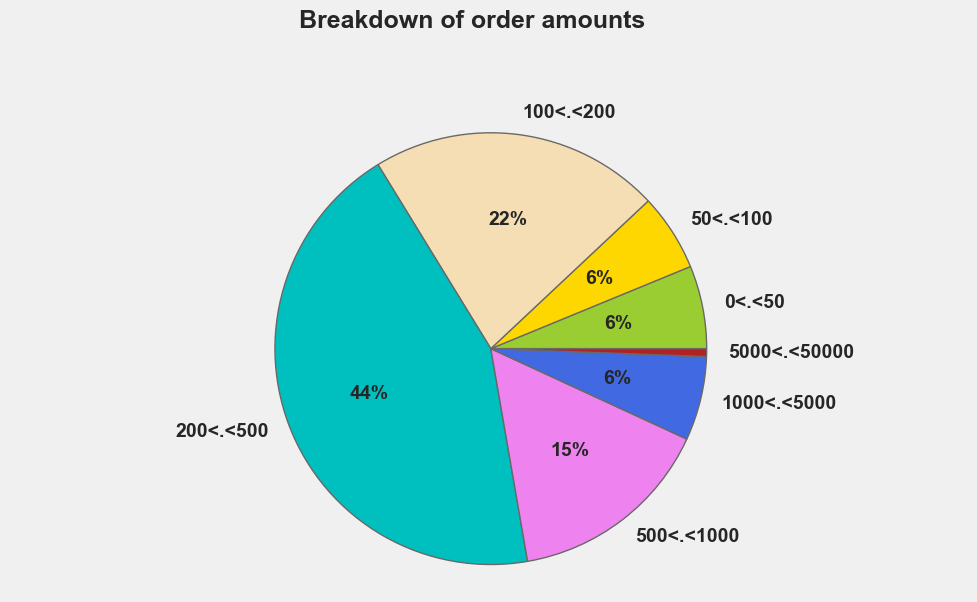

In [ ]:

price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Breakdown of order amounts", ha='center', fontsize = 18);

It can be seen that the vast majority of orders concern relatively large purchases given that $\sim$65% of purchases give prizes in excess of £ 200.

____
## 3. Insight on product categories


___
### 3.1 Products Description


In [ ]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()

    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]

        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1

    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]

    print("No of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as input the dataframe and analyzes the content of the **Description** column by performing the following operations:

- extract the names (proper, common) appearing in the products description
- for each name, weextract the root of the word and aggregate the set of names associated with this particular root
- count the number of times each root appears in the dataframe
- when several words are listed for the same root, weconsider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)

The first step of the analysis is to retrieve the list of products:

In [ ]:
df_products = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

Once this list is created, weuse the function wepreviously defined in order to analyze the description of the various products:

In [ ]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

No of keywords in variable 'Description': 1483


The execution of this function returns three variables:
- `keywords`: the list of extracted keywords
- `keywords_roots`: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
- `count_keywords`: dictionary listing the number of times every word is used

At this point, weconvert the `count_keywords` dictionary into a list, to sort the keywords according to their occurences:

In [ ]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Using it, wecreate a representation of the most common keywords:

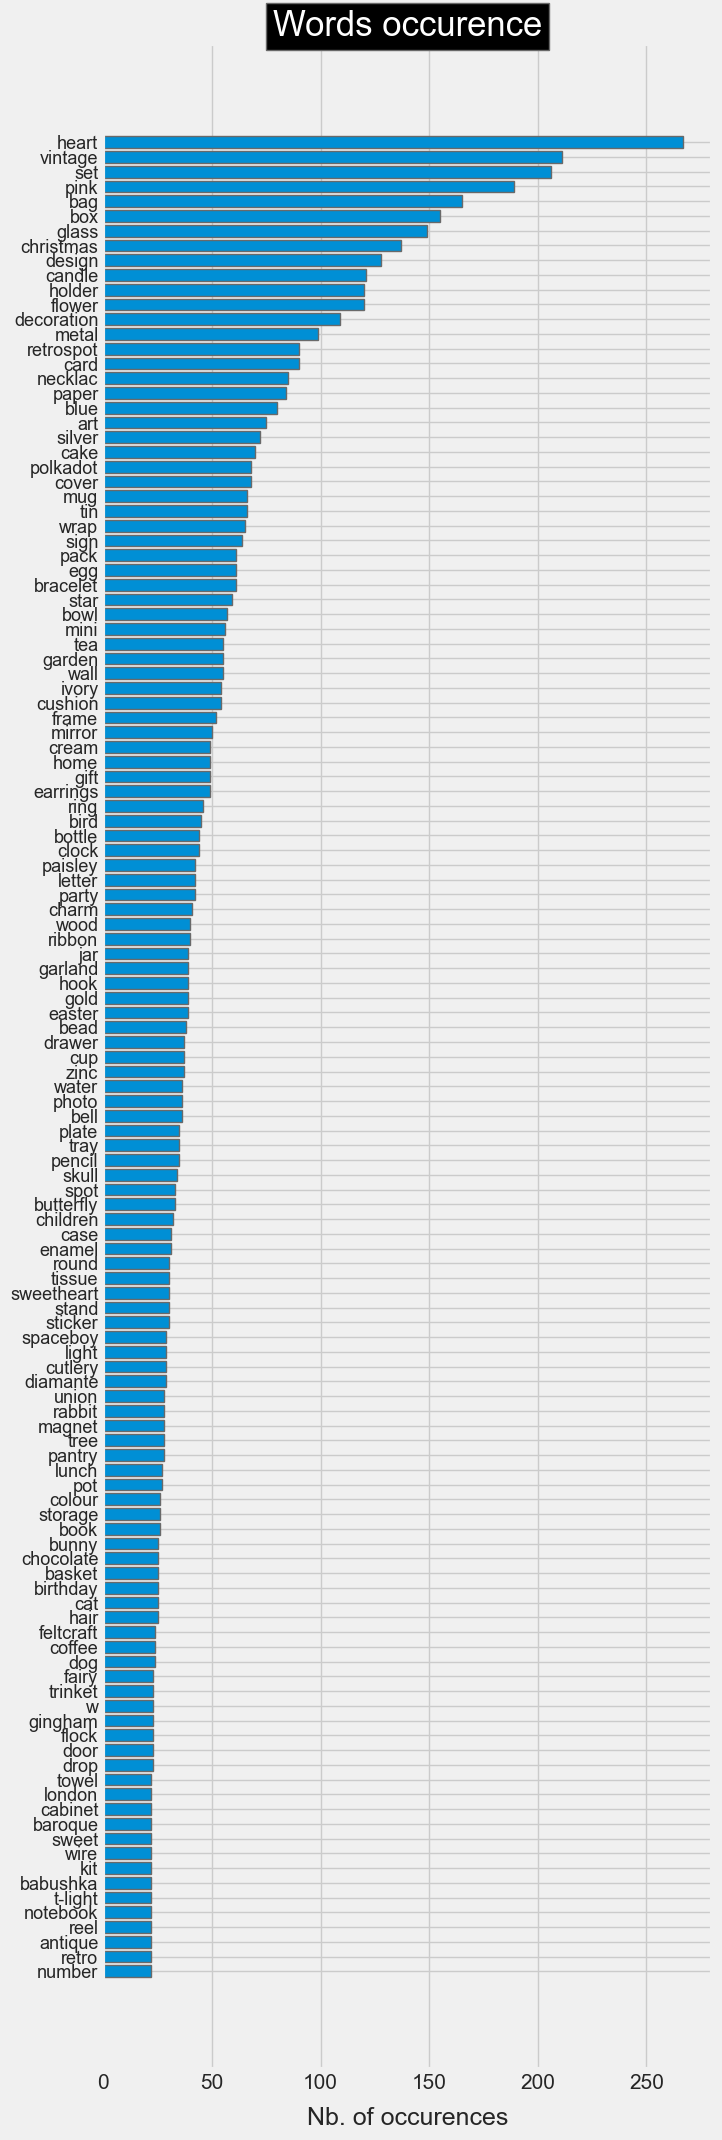

In [ ]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("No. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

___
### 3.2 Defining product categories

In [ ]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________
list_products.sort(key = lambda x:x[1], reverse = True)
print('Preserved words:', len(list_products))

Preserved words: 193


____
#### 3.2.1 Data encoding

Now wewill use these keywords to create groups of product. Firstly, wedefine the $X$ matrix as:

   
|           | word 1    |  ...  | word j  | ...  | word N  |
|:---------:|-----------|---|---|---|---|
| product 1 | $a_{1,1}$ |     |   |   | $a_{1,N}$  |
|    ...    |           |     | ...  |   |   |
| product i | ...       |     | $a_{i,j}$    |   | ...  |
|    ...    |           |     |  ... |   |   |
| product M | $a_{M,1}$ |     |   |   | $a_{M,N}$   |

where the $a_ {i, j}$ coefficient  is 1 if the description of the product $i$ contains the word $j$, and 0 otherwise.

In [ ]:
liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in liste_produits:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))

The $X$ matrix indicates the words contained in the description of the products using the *one-hot-encoding* principle. In practice, we have found that introducing the price range results in more balanced groups in terms of element numbers.
Hence, we add 6 extra columns to this matrix, where we indicate the price range of the products:

In [ ]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

and to choose the appropriate ranges, We check the number of products in the different groups:

In [ ]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


____
#### 3.2.2 Creating clusters of products

K-Means Clustering (Euclidean Distance)

In order to define (approximately) the number of clusters that best represents the data, we use the silhouette score:

In [ ]:
matrix = X.to_numpy()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10158702596012364
For n_clusters = 4 The average silhouette_score is : 0.120602965628421
For n_clusters = 5 The average silhouette_score is : 0.12603269728618594
For n_clusters = 6 The average silhouette_score is : 0.1432814800931487
For n_clusters = 7 The average silhouette_score is : 0.14815857682753922
For n_clusters = 8 The average silhouette_score is : 0.14932847870021357
For n_clusters = 9 The average silhouette_score is : 0.15676226373834637


In practice, the scores obtained above can be considered equivalent since, depending on the run, scores of $ 0.1 \pm 0.05 $ will be obtained for all clusters with `n_clusters` $> $ 3 (we obtain slightly lower scores for the first cluster). On the other hand, we found that beyond 5 clusters, some clusters contained very few elements. We therefore choose to separate the dataset into 5 clusters. In order to ensure a good classification at every run of the notebook, we iterate until we obtain the best possible silhouette score, which is, in the present case, around 0.15:

In [ ]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)


    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.12670138195616623
For n_clusters = 5 The average silhouette_score is : 0.14708700459493795


___
#### 3.2.3  Characterizing the content of clusters

We check the number of elements in every class:

In [ ]:
pd.Series(clusters).value_counts()

0    1009
2     964
1     762
3     673
4     470
dtype: int64

In [ ]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):

        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)

        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))

        y_lower = y_upper + 10

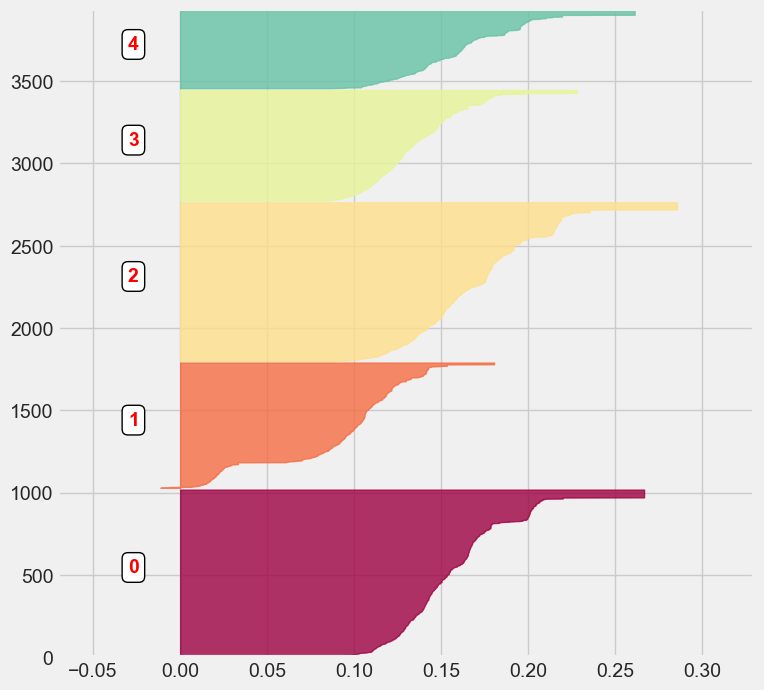

In [ ]:
sample_silhouette_values = silhouette_samples(matrix, clusters)
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

In [ ]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

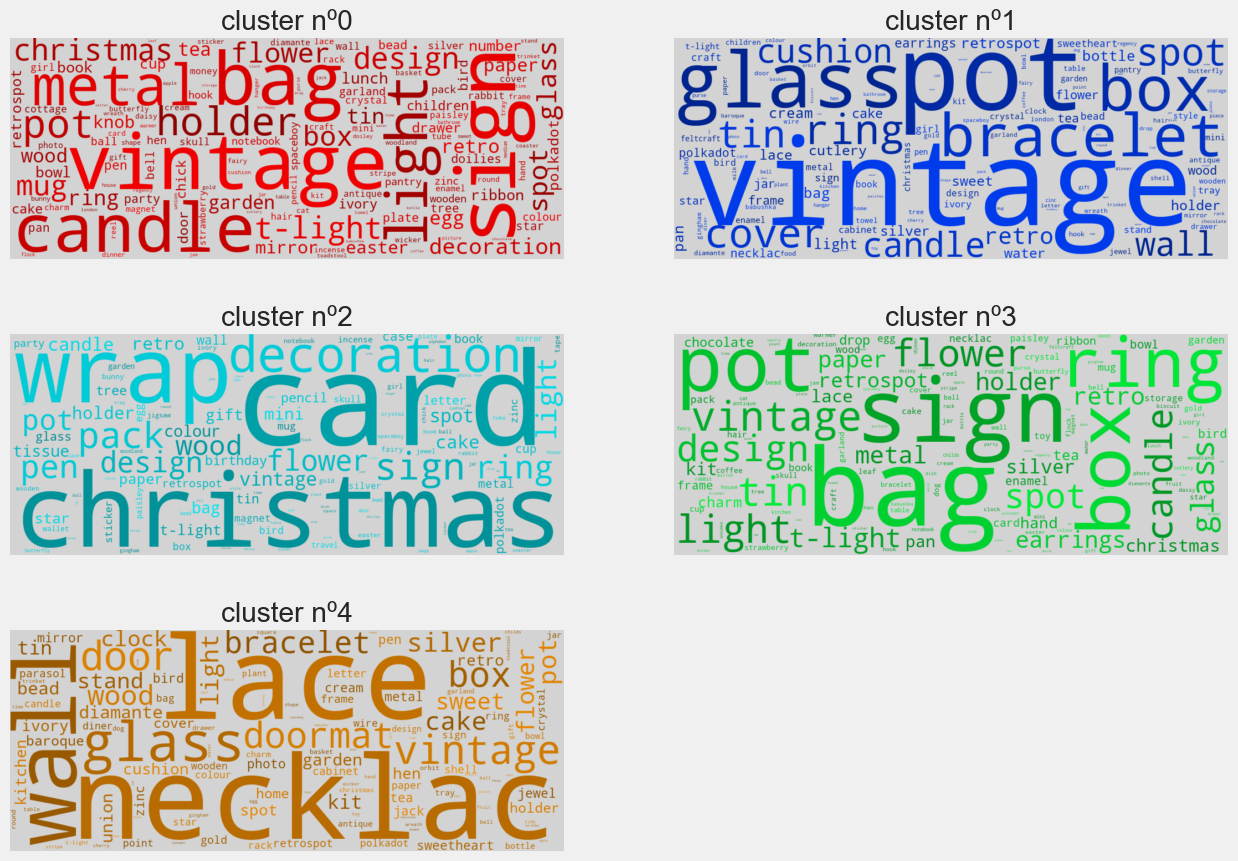

In [ ]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]

    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey',
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))

fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)

From this representation, we can see that for example, one of the clusters contains objects that could be associated with gifts (keywords: Christmas, packaging, card, ...). Another cluster would rather contain luxury items and jewelry (keywords: necklace, bracelet, lace, silver, ...). Nevertheless, it can also be observed that many words appear in various clusters and it is therefore difficult to clearly distinguish them.

** c / _Principal Component Analysis_ **

In order to ensure that these clusters are truly distinct, we look at their composition. Given the large number of variables of the initial matrix, we first perform a PCA:

In [ ]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

and then check for the amount of variance explained by each component:

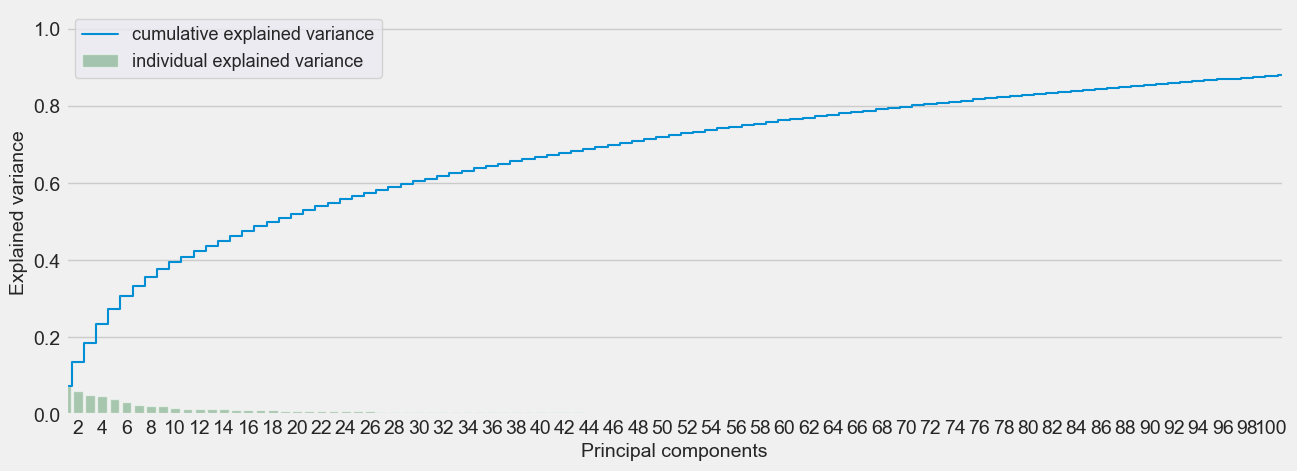

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

We see that the number of components required to explain the data is extremely important: we need more than 100 components to explain 90% of the variance of the data. In practice, we decide to keep only a limited number of components since this decomposition is only performed to visualize the data:

In [ ]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

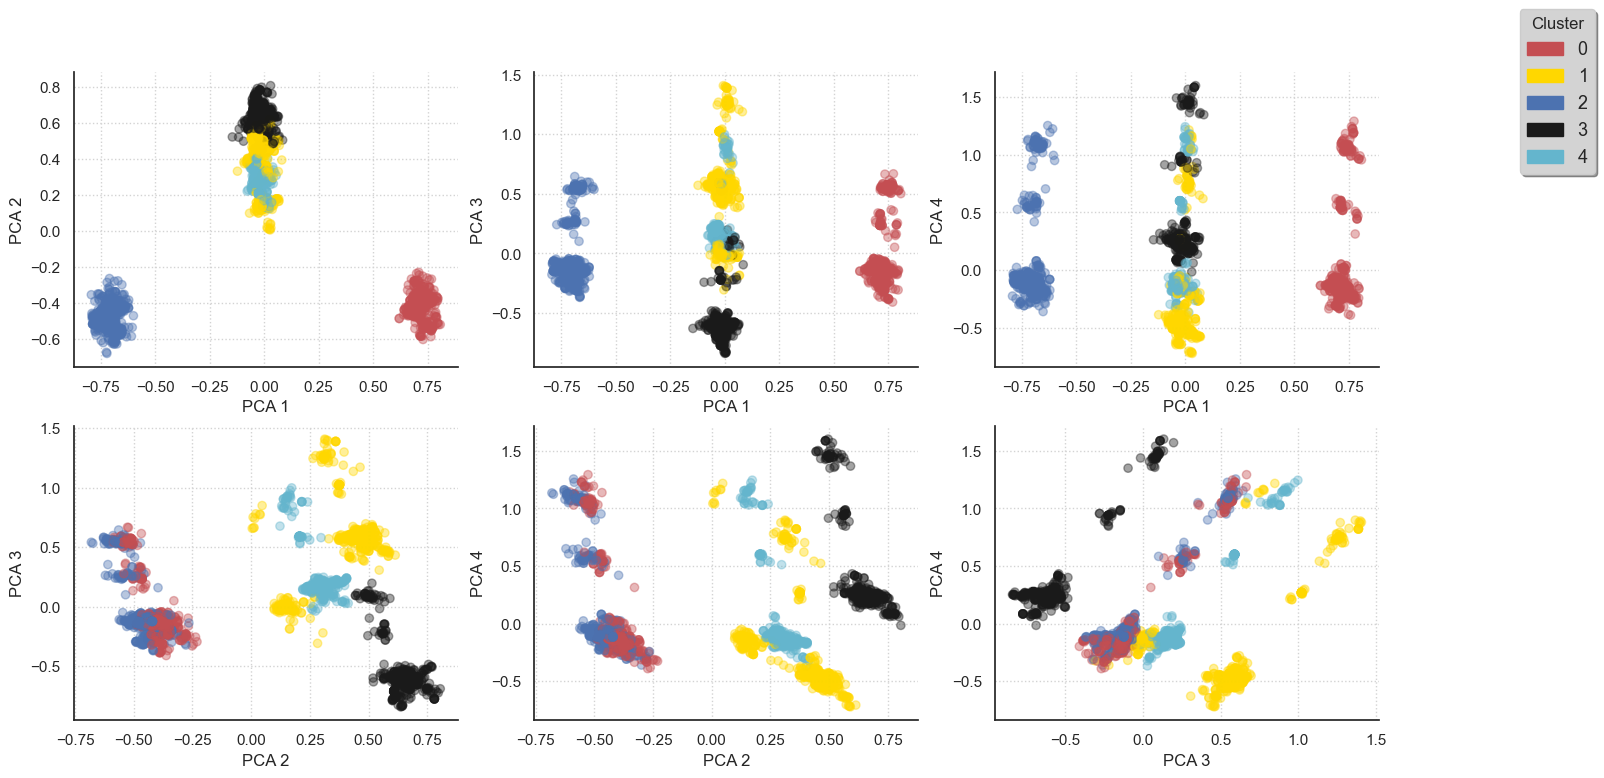

In [ ]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4)
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        if increment == 9: break
    if increment == 9: break


comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97),
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

___
## 4. Customer categories

### 4.1 Formatting data

In the previous section, the different products were grouped in five clusters. In order to prepare the rest of the analysis, a first step consists in introducing this information into the dataframe. To do this, we create the categorical variable **categ_product** where we indicate the cluster of each product :

In [ ]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val
#__________________________________________________________________________
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

___
#### 4.1.1 Grouping products

In a second step, we decide to create the **categ_N** variables (with $ N \in [0: 4]$) that contains the amount spent in each product category:

In [ ]:
for i in range(5):
    col = 'categ_{}'.format(i)
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,3,0.0,0.00,0.0,15.3,0.0
1,536365,WHITE METAL LANTERN,1,0.0,20.34,0.0,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,1,0.0,22.00,0.0,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,1,0.0,20.34,0.0,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,1,0.0,20.34,0.0,0.0,0.0


Up to now, the information related to a single order was split over several lines of the dataframe (one line per product). we decide to collect the information related to a particular order and put in a single entry. we therefore create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:

In [ ]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

for i in range(5):
    col = 'categ_{}'.format(i)
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp[col]

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,187.2,293.35,23.40,83.40,124.44,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,130.5,207.45,84.34,53.10,0.00,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,330.9,153.25,81.00,71.10,0.00,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,74.4,168.76,41.40,78.06,19.90,2011-06-09 13:01:00.000000000
5,12347,562032,584.91,109.7,196.41,61.30,119.70,97.80,2011-08-02 08:48:00.000000000


____
#### 4.1.2 Consumer Order Combinations

In a second step, we group together the different entries that correspond to the same user, thus determining the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

In [ ]:

transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,5,382.52,711.79,558.172000,2790.86,29.836681,36.519926,10.442659,14.524555,8.676179
1,12348,4,227.44,892.80,449.310000,1797.24,41.953217,20.030714,38.016069,0.000000,0.000000
2,12350,1,334.40,334.40,334.400000,334.40,48.444976,11.961722,11.692584,27.900718,0.000000
3,12352,6,144.35,840.30,345.663333,2073.98,12.892120,68.944734,0.491808,3.370331,14.301006
4,12353,1,89.00,89.00,89.000000,89.00,13.033708,44.719101,0.000000,19.887640,22.359551


In [ ]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,5,382.52,711.79,558.172000,2790.86,29.836681,36.519926,10.442659,14.524555,8.676179,59,297
1,12348,4,227.44,892.80,449.310000,1797.24,41.953217,20.030714,38.016069,0.000000,0.000000,5,288
2,12350,1,334.40,334.40,334.400000,334.40,48.444976,11.961722,11.692584,27.900718,0.000000,240,240
3,12352,6,144.35,840.30,345.663333,2073.98,12.892120,68.944734,0.491808,3.370331,14.301006,2,226
4,12353,1,89.00,89.00,89.000000,89.00,13.033708,44.719101,0.000000,19.887640,22.359551,134,134


In [ ]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("No. of clients with single orders: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

No. of clients with single orders: 0 /2551  (0.00%)


___
### 4.2 Creation of customers categories

#### 4.2.1 Data encoding


In [ ]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']

selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].to_numpy()

In [ ]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.62305987 259.93189634 556.26687999 377.06036244  25.22916919
  23.91238925  13.98907929  21.19884856  15.67936332]


In [ ]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

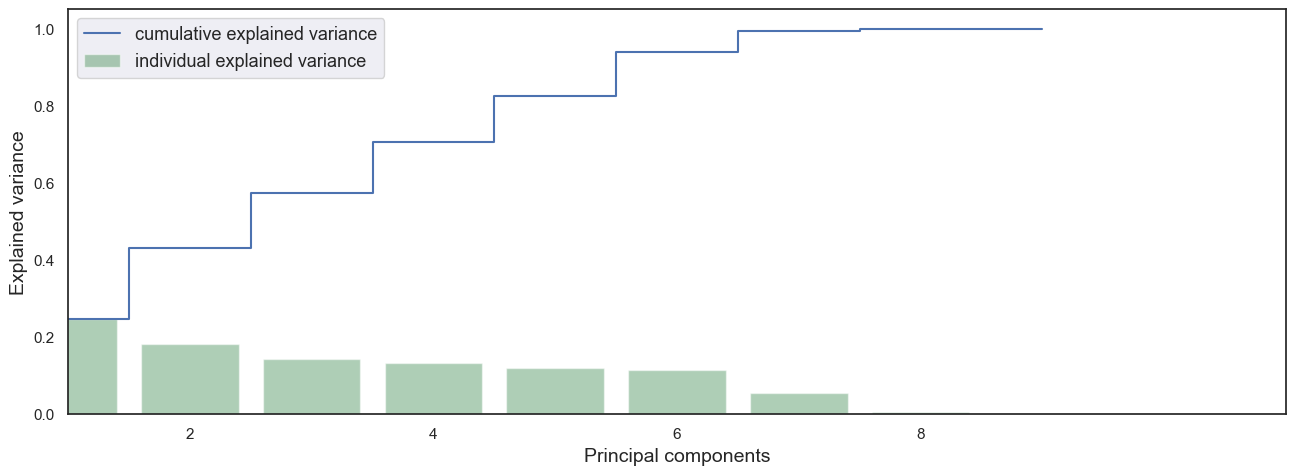

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

___
#### 4.2.2 Creation of customer categories

In [ ]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.212


At first, we look at the number of customers in each cluster:

In [ ]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T

,0,10,1,5,3,6,7,9,2,4,8
nb. de clients,1460,479,428,350,296,231,184,154,10,9,7


** a / _Report via the PCA_ **

There is a certain disparity in the sizes of different groups that have been created. Hence we will now try to understand the content of these clusters in order to validate (or not) this particular separation. At first, we use the result of the PCA:

In [ ]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

in order to create a representation of the various clusters:

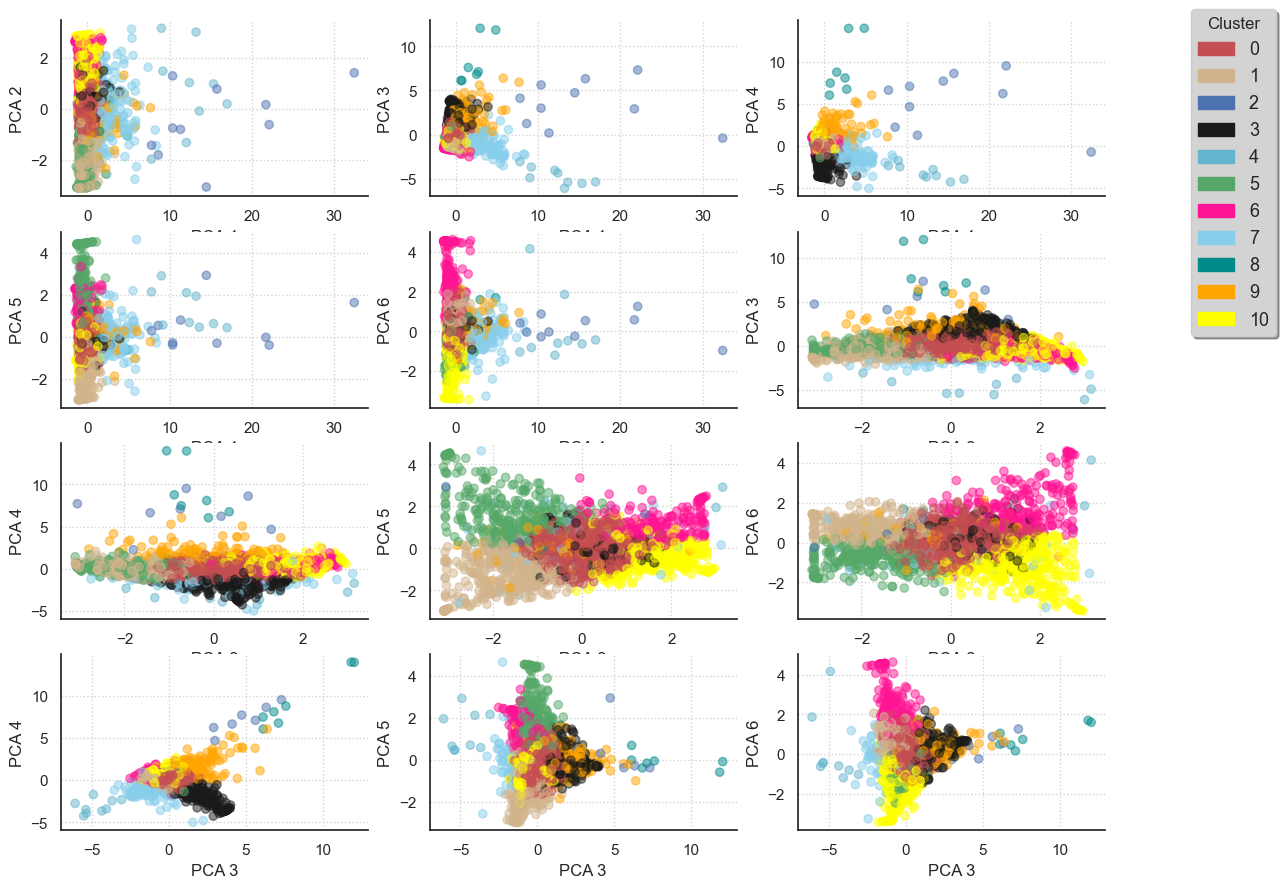

In [ ]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5)
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        if increment == 12: break
    if increment == 12: break


comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9),
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

From this representation, it can be seen, for example, that the first principal component allow to separate the tiniest clusters from the rest. More generally, we see that there is always a representation in which two clusters will appear to be distinct.

** b/ _Score de silhouette intra-cluster_ **

As with product categories, another way to look at the quality of the separation is to look at silouhette scores within different clusters:

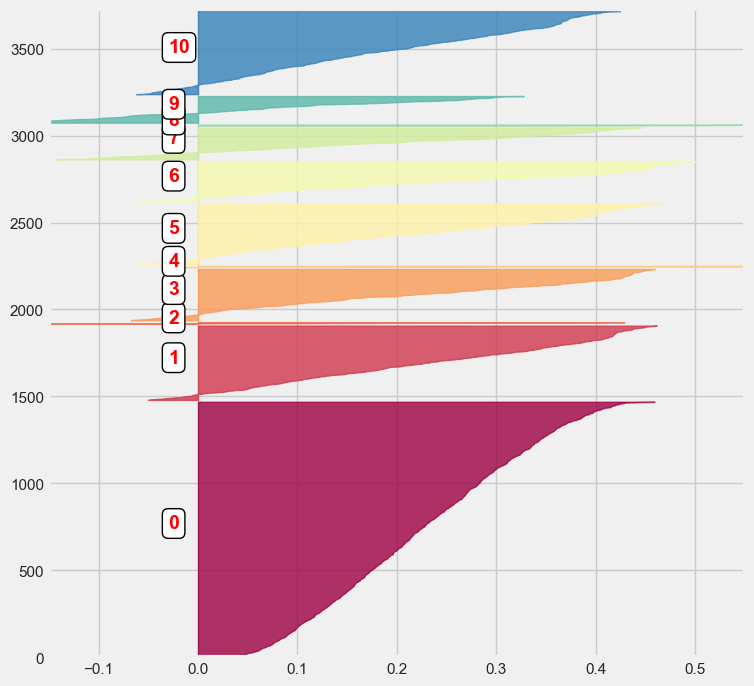

In [ ]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

In [ ]:
selected_customers.loc[:, 'cluster'] = clusters_clients

In [ ]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3608


In [ ]:
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])
#___________________________________
liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]
#___________________________________________________________
merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,10.0,2.442589,217.872234,334.874115,273.321707,677.662737,56.586462,11.336433,13.142386,12.845693,6.092133,479
1,1.0,2.228972,211.118388,359.386495,274.603436,701.985164,10.618549,59.794130,5.162605,11.548379,12.899205,428
2,6.0,2.199134,193.774026,317.699913,247.165261,582.228312,18.052858,7.841102,57.570041,11.101421,5.434577,231
3,3.0,2.591216,208.244899,378.735439,289.490999,817.999155,15.311922,9.751534,6.992741,60.529606,7.414197,296
4,5.0,2.502857,192.872803,312.765600,246.358670,637.946117,11.688894,19.315748,5.298483,11.562019,52.150979,350
5,0.0,3.280822,217.493939,457.964658,328.764453,1088.353645,25.712352,23.856945,13.864776,22.207977,14.365915,1460
6,7.0,1.695652,1079.824076,1421.540495,1236.065300,2192.009788,25.983635,26.237784,12.071210,21.912537,13.795200,184
7,4.0,1.222222,3901.461111,4064.098889,3982.780000,5032.047778,20.388127,21.867950,26.370713,11.852002,19.521209,9
8,9.0,18.233766,88.550195,1600.436688,574.904444,9926.581234,23.878568,22.950422,12.209346,25.442253,15.539758,154
9,8.0,92.000000,10.985714,1858.250000,374.601553,34845.105714,25.832531,20.826842,13.117583,22.527857,17.721038,7


In [ ]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]

        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True,
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)

        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)

        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")

        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])

        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)

    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)




____
## 5. Classification of customers



In [ ]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)

    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)

    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))


In [ ]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

___
### 5.1 Support Vector Machine Classifier (SVC)

parameters:
- the hyperparameters for which we seek an optimal value
- the number of folds to be used for cross-validation

In [ ]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

In [ ]:
svc.grid_fit(X = X_train, Y = Y_train)

In [ ]:
svc.grid_predict(X_test, Y_test)

Precision: 77.56 % 


___
#### 5.1.1 Confusion matrix



In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


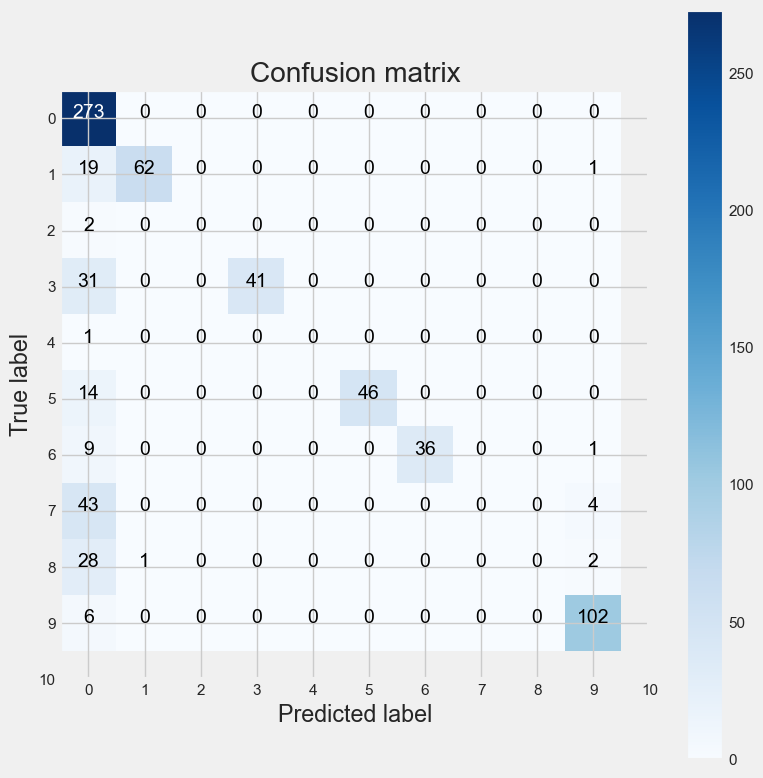

In [ ]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions)
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

___
#### 5.1.2 Learning curve



In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

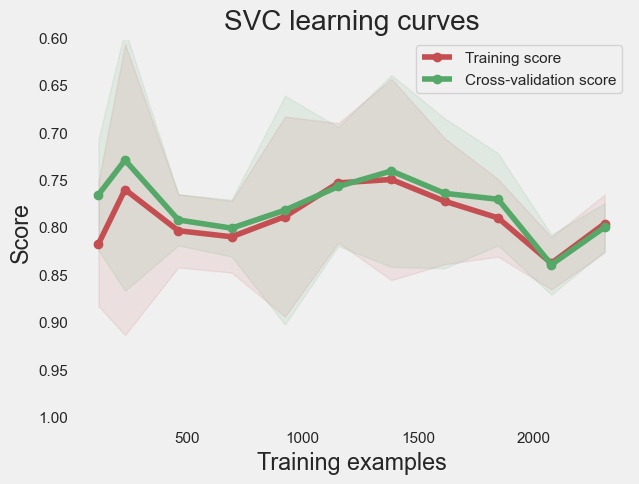

In [ ]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

The train and cross-validation curves converge towards the same limit when the sample size increases. This is typical of modeling with low variance and proves that the model does not suffer from overfitting. Also, we can see that the accuracy of the training curve is correct which is synonymous of a low bias. Hence the model does not underfit the data.

___
### 5.2 Logistic Regression



In [ ]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 91.00 % 


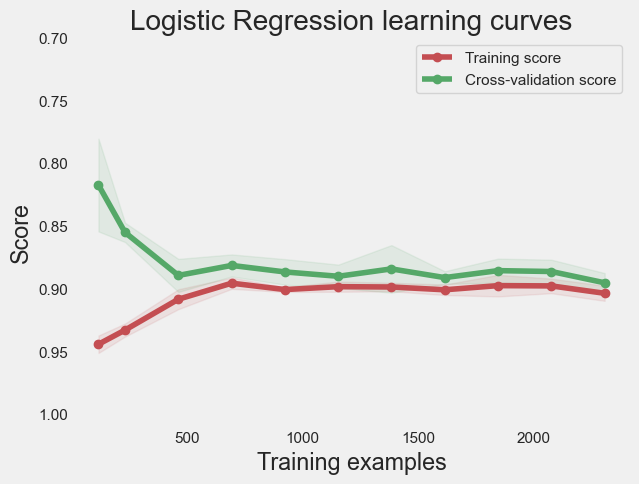

In [ ]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.3 k-Nearest Neighbors

In [ ]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 78.95 % 


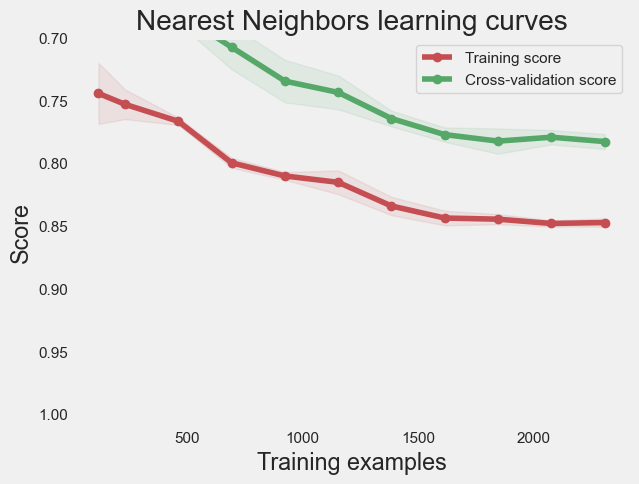

In [ ]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.4 Decision Tree

In [ ]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 86.70 % 


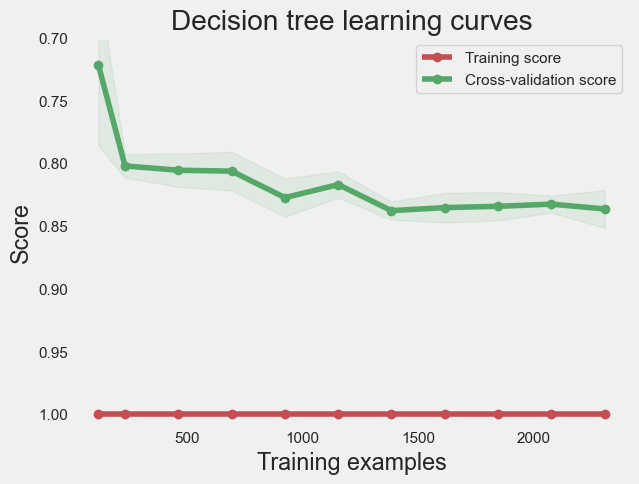

In [ ]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.5 Random Forest

In [ ]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 91.69 % 


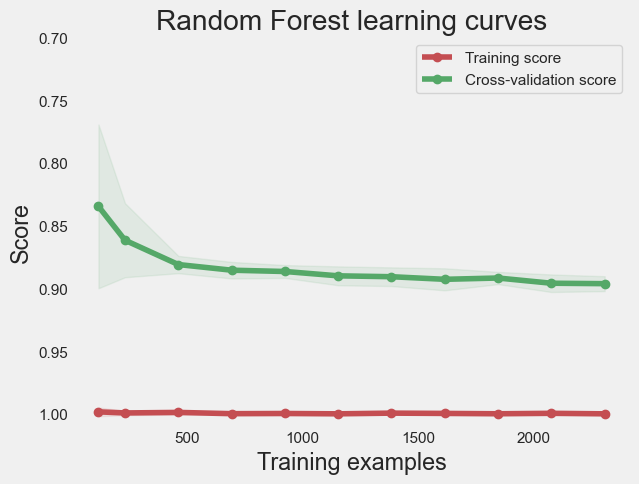

In [ ]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

___

